In [2]:
# Importer les bibliothèques nécessaires
import numpy as np
from keras.applications import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
import os
from glob import glob
import re
import shutil
import cv2

In [3]:
# Charger ResNet50 sans la couche de classification
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

In [4]:
def extract_features(img, model):
    # Redimensionner l'image à 224x224 pixels
    img = img.resize((224, 224))
    # Convertir l'image en un tableau numpy
    x = image.img_to_array(img)
    # Ajouter une dimension (pour représenter le batch de 1 image)
    x = np.expand_dims(x, axis=0)
    # Prétraiter l'image pour ResNet
    x = preprocess_input(x)
    # Passer l'image dans le modèle pour extraire les features
    features = model.predict(x)
    # Aplatir le vecteur de sortie (c'est déjà un vecteur de 2048, donc facultatif ici)
    return features.flatten()


On réalise 2 fonctions de découpage d'images, une pour les caméras du haut où le ciel prédomine et l'autre pour les caméras du bas où la mer prédomine. Le but est, pour les 2 groupes d'images, d'isoler un rectangle de ciel (resp de mer) pour que le clustering se fasse exclusivement en fonction de l'état du ciel (resp de la mer). Le but sera de mettre ces fonctions dans un fichier .py réalisé par Timothée pour pouvoir les appeler

In [5]:
from PIL import Image

#Fonction qui découpe un rectangle dans le ciel

from PIL import Image

def decoupe_rectangle_ciel(image):
    # Dimensions du rectangle à découper
    crop_width = 1561
    crop_height = 780

    # Calculer les coordonnées du rectangle à découper
    width, height = image.size
    left = (width - crop_width) / 2
    top = 0
    right = left + crop_width
    bottom = top + crop_height

    # Découper l'image
    cropped_image = image.crop((left, top, right, bottom))

    return cropped_image



In [6]:
from PIL import Image

#Fonction qui découpe un rectangle dans la mer

def decoupe_rectangle_mer(image):
    # Dimensions du carré à découper
    crop_size = 820
    offset = 126

    # Calculer les coordonnées du carré à découper au centre de l'image avec décalage à droite
    width, height = image.size
    left = (width - crop_size) / 2 + offset
    top = (height - crop_size) / 2
    right = left + crop_size
    bottom = top + crop_size

    # Découper l'image
    cropped_image = image.crop((left, top, right, bottom))

    return cropped_image




 # Adapatation de l'algorithme initial de resNet 50

Il s'agit ici de reprendre l'algorithme initiallement utilisé pour extraire les features des images grâce à ResNet50. Cependant, on ajoute une modification, en fonction du titre de l'image (qui contient le numero de frame) on classe l'image dans une des 2 listes photos_ciel et photos_mer. On peut ensuite appliquer les 2 fonctions ci-dessus pour extraire un rectangle de l'image pour chacune des 2 listes en créant ainsi 2 nouvelles listes: extraits_photos_ciel et extraits_photos_mer. On applique ResNet50 à ces 2 listes

In [7]:
import glob
import numpy as np
import os
from PIL import Image

# Initialiser les listes pour stocker les photos
photos_ciel = []
photos_mer = []

# Listes pour les images découpées
photos_ciel_découpés = []
photos_mer_découpés = []

# Listes pour stocker les features
features_ciel_list = []
features_mer_list = []

# Chemin vers le dossier d'images
dossier_images = "../../DATASET_SENSEA/images"
print(os.path.exists(dossier_images))  # Vérifie si le chemin existe

# Chemin vers les sous-dossiers photos_ciel et photos_mer
photos_ciel_path = os.path.join(dossier_images, "photos_ciel")
photos_mer_path = os.path.join(dossier_images, "photos_mer")

True


!! à éxécuter pour classer les images dans les deux dossiers différents si déjà fait pas besoin !!

In [8]:
# Créer les dossiers s'ils n'existent pas déjà
os.makedirs(photos_ciel_path, exist_ok=True)
os.makedirs(photos_mer_path, exist_ok=True)

# Liste de tous les fichiers dans le dossier images
fichiers = [f for f in os.listdir(dossier_images) if f.endswith(".jpg")]

# Expression régulière pour extraire le numéro avant 'frame'
pattern = re.compile(r"frame=(\d+)")

# Trier les fichiers
for fichier in fichiers:
    # Trouver le chemin complet du fichier
    chemin_complet = os.path.join(dossier_images, fichier)
    
    # Extraire le numéro avant 'frame'
    match = pattern.search(fichier)
    if match:
        numero_frame = int(match.group(1))
        
        # Vérifier si le numéro est pair ou impair
        if numero_frame % 2 == 0:
            # Déplacer vers photos_ciel (nombres pairs)
            shutil.move(chemin_complet, os.path.join(photos_ciel_path, fichier))
            print(f"Déplacé dans photos_ciel : {fichier}")
        else:
            # Déplacer vers photos_mer (nombres impairs)
            shutil.move(chemin_complet, os.path.join(photos_mer_path, fichier))
            print(f"Déplacé dans photos_mer : {fichier}")
    else:
        print(f"Nom de fichier non conforme : {fichier}")

In [9]:
# Paramètres pour réduire le nombre d'images traitées
N = 100  # Traiter une image sur N pour réduire le temps d'exécution

# Liste des images dans chaque dossier
photos_ciel = glob.glob(os.path.join(photos_ciel_path, "*.jpg"))
photos_mer = glob.glob(os.path.join(photos_mer_path, "*.jpg"))

# Afficher la taille des listes photos_ciel et photos_mer
print(f"Nombre d'images dans photos_ciel: {len(photos_ciel)}")
print(f"Nombre d'images dans photos_mer: {len(photos_mer)}")

# Paramétrer un filtrage pour limiter les images traitées (1 image sur N)
photos_ciel_filtered = photos_ciel[::N]
photos_mer_filtered = photos_mer[::N]

# Afficher la taille après filtrage
print(f"Nombre d'images filtrées pour photos_ciel: {len(photos_ciel_filtered)}")
print(f"Nombre d'images filtrées pour photos_mer: {len(photos_mer_filtered)}")

# Découper les images du ciel
for img_path in photos_ciel_filtered:
    with Image.open(img_path) as img:
        extrait_ciel = decoupe_rectangle_ciel(img)  
        photos_ciel_découpés.append(extrait_ciel)

# Afficher la taille de la liste des images découpées pour le ciel
print(f"Nombre d'images découpées pour photos_ciel: {len(photos_ciel_découpés)}")

# Découper les images de la mer
for img_path in photos_mer_filtered:
    with Image.open(img_path) as img:
        extrait_mer = decoupe_rectangle_mer(img)  
        photos_mer_découpés.append(extrait_mer)

# Afficher la taille de la liste des images découpées pour la mer
print(f"Nombre d'images découpées pour photos_mer: {len(photos_mer_découpés)}")

# Extraire les features des images découpées pour le ciel
for img in photos_ciel_découpés:
    features_ciel = extract_features(img, model)
    features_ciel_list.append(features_ciel)  

# Afficher la taille de la liste des features pour le ciel
print(f"Nombre de features extraites pour photos_ciel: {len(features_ciel_list)}")

# Extraire les features des images découpées pour la mer
for img in photos_mer_découpés:
    features_mer = extract_features(img, model)  
    features_mer_list.append(features_mer)

# Afficher la taille de la liste des features pour la mer
print(f"Nombre de features extraites pour photos_mer: {len(features_mer_list)}")

# Convertir les listes de features en tableaux numpy
features_ciel_array = np.array(features_ciel_list)
features_mer_array = np.array(features_mer_list)

# Afficher la forme des tableaux numpy
print(f"Shape of features_ciel_array: {features_ciel_array.shape}")
print(f"Shape of features_mer_array: {features_mer_array.shape}")


Nombre d'images dans photos_ciel: 10331
Nombre d'images dans photos_mer: 10274
Nombre d'images filtrées pour photos_ciel: 104
Nombre d'images filtrées pour photos_mer: 103
Nombre d'images découpées pour photos_ciel: 104
Nombre d'images découpées pour photos_mer: 103
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/

In [10]:
from sklearn.decomposition import PCA

# Supposons que `features_array` soit le tableau de features de 2048 dimensions (chaque ligne est un vecteur de features pour une image)
# Vérifions sa taille pour être sûr
print(features_ciel_array.shape)  # Par exemple, (num_images, 2048)
print(features_mer_array.shape)  

# On applique PCA pour réduire à un nombre de dimensions réduit, ici 50 pour l'exemple
pca = PCA(n_components=50)
reduced_features_ciel = pca.fit_transform(features_ciel_array)
reduced_features_mer = pca.fit_transform(features_mer_array)



# Affichage des dimensions après réduction
print(reduced_features_mer.shape)  # Par exemple, (num_images, 50)
print(reduced_features_ciel.shape) 

(104, 2048)
(103, 2048)
(103, 50)
(104, 50)


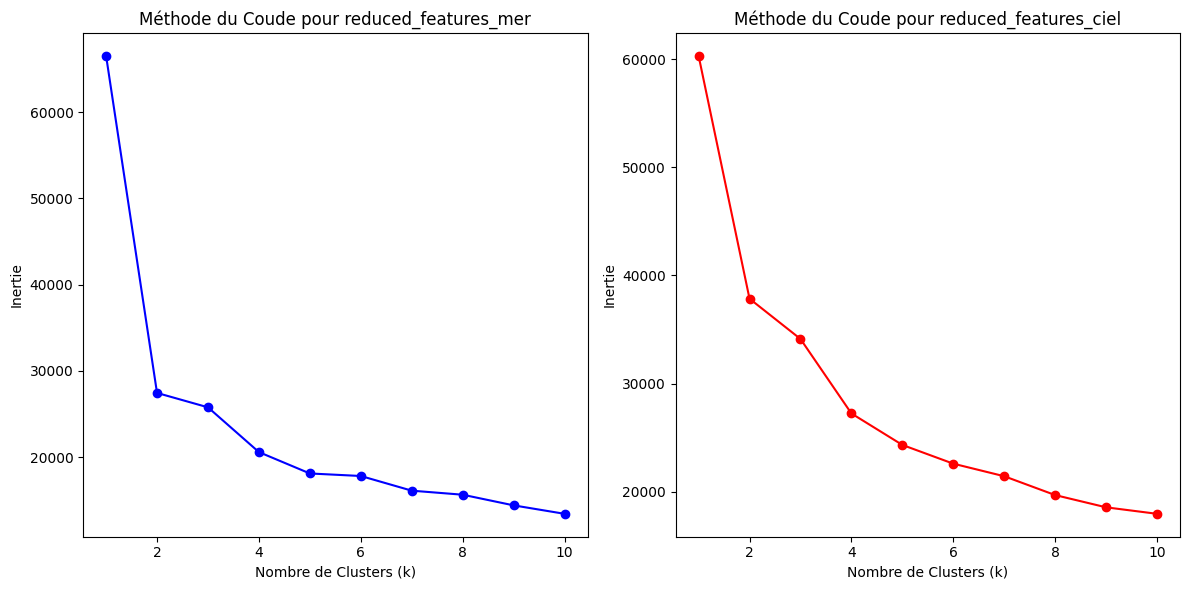

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Liste pour stocker les inerties
inertias_mer = []
inertias_ciel = []

# Tester K-means pour différents nombres de clusters (de 1 à 10)
for k in range(1, 11):
    # Appliquer KMeans sur reduced_features_mer
    kmeans_mer = KMeans(n_clusters=k, random_state=0)
    kmeans_mer.fit(reduced_features_mer)  # Utilisez reduced_features_mer pour la mer
    inertias_mer.append(kmeans_mer.inertia_)

    # Appliquer KMeans sur reduced_features_ciel
    kmeans_ciel = KMeans(n_clusters=k, random_state=0)
    kmeans_ciel.fit(reduced_features_ciel)  # Utilisez reduced_features_ciel pour le ciel
    inertias_ciel.append(kmeans_ciel.inertia_)

# Tracer le graphique de la méthode du coude pour reduced_features_mer
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Premier graphique
plt.plot(range(1, 11), inertias_mer, marker='o', color='b')
plt.xlabel('Nombre de Clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du Coude pour reduced_features_mer')

# Tracer le graphique de la méthode du coude pour reduced_features_ciel
plt.subplot(1, 2, 2)  # Deuxième graphique
plt.plot(range(1, 11), inertias_ciel, marker='o', color='r')
plt.xlabel('Nombre de Clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du Coude pour reduced_features_ciel')

# Afficher les graphiques
plt.tight_layout()
plt.show()


In [12]:
from sklearn.cluster import KMeans

# Choisir le nombre optimal de clusters (exemple avec k=5)
k_optimal = 5

# Appliquer K-means pour reduced_features_mer
kmeans_mer = KMeans(n_clusters=k_optimal, random_state=0)
labels_kmeans_mer = kmeans_mer.fit_predict(reduced_features_mer)  # Appliquer K-Means sur reduced_features_mer

# Afficher les étiquettes des clusters pour chaque image de reduced_features_mer
print("Étiquettes des clusters pour reduced_features_mer:")
print(labels_kmeans_mer)

# Appliquer K-means pour reduced_features_ciel
kmeans_ciel = KMeans(n_clusters=k_optimal, random_state=0)
labels_kmeans_ciel = kmeans_ciel.fit_predict(reduced_features_ciel)  # Appliquer K-Means sur reduced_features_ciel

# Afficher les étiquettes des clusters pour chaque image de reduced_features_ciel
print("Étiquettes des clusters pour reduced_features_ciel:")
print(labels_kmeans_ciel)


Étiquettes des clusters pour reduced_features_mer:
[3 3 1 3 2 1 2 3 3 3 2 3 0 3 3 0 0 0 1 1 2 1 1 1 2 2 3 0 0 0 1 1 1 2 3 3 4
 2 2 3 3 3 3 2 2 2 2 2 1 1 1 2 2 3 1 0 0 2 2 2 1 3 2 2 3 3 3 3 2 2 2 2 2 2
 1 1 4 3 3 4 4 4 2 0 3 2 3 2 2 0 0 3 3 3 2 3 2 2 2 2 2 2 3]
Étiquettes des clusters pour reduced_features_ciel:
[1 1 1 1 0 3 4 3 3 3 0 3 2 3 3 2 2 2 1 1 2 1 1 3 2 2 1 2 2 2 2 3 3 0 1 1 1
 2 2 1 1 1 1 0 0 2 2 4 2 2 1 1 1 1 2 2 1 0 0 4 3 3 4 0 3 3 1 3 3 4 4 4 4 3
 1 1 0 1 1 3 3 0 4 4 0 2 3 4 4 4 2 3 2 3 3 0 0 0 4 4 4 4 4 1]


In [13]:
def afficher_photos_aleatoires(images, labels_kmeans, num_photos=50):
    indices = np.random.choice(len(images), num_photos, replace=False)
    nb_colonnes = 10
    nb_lignes = num_photos // nb_colonnes + (num_photos % nb_colonnes > 0)

    plt.figure(figsize=(15, nb_lignes * 1.5))

    for i, idx in enumerate(indices):
        plt.subplot(nb_lignes, nb_colonnes, i + 1)
        plt.imshow(images[idx])
        plt.title(f'Cluster {labels_kmeans[idx]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


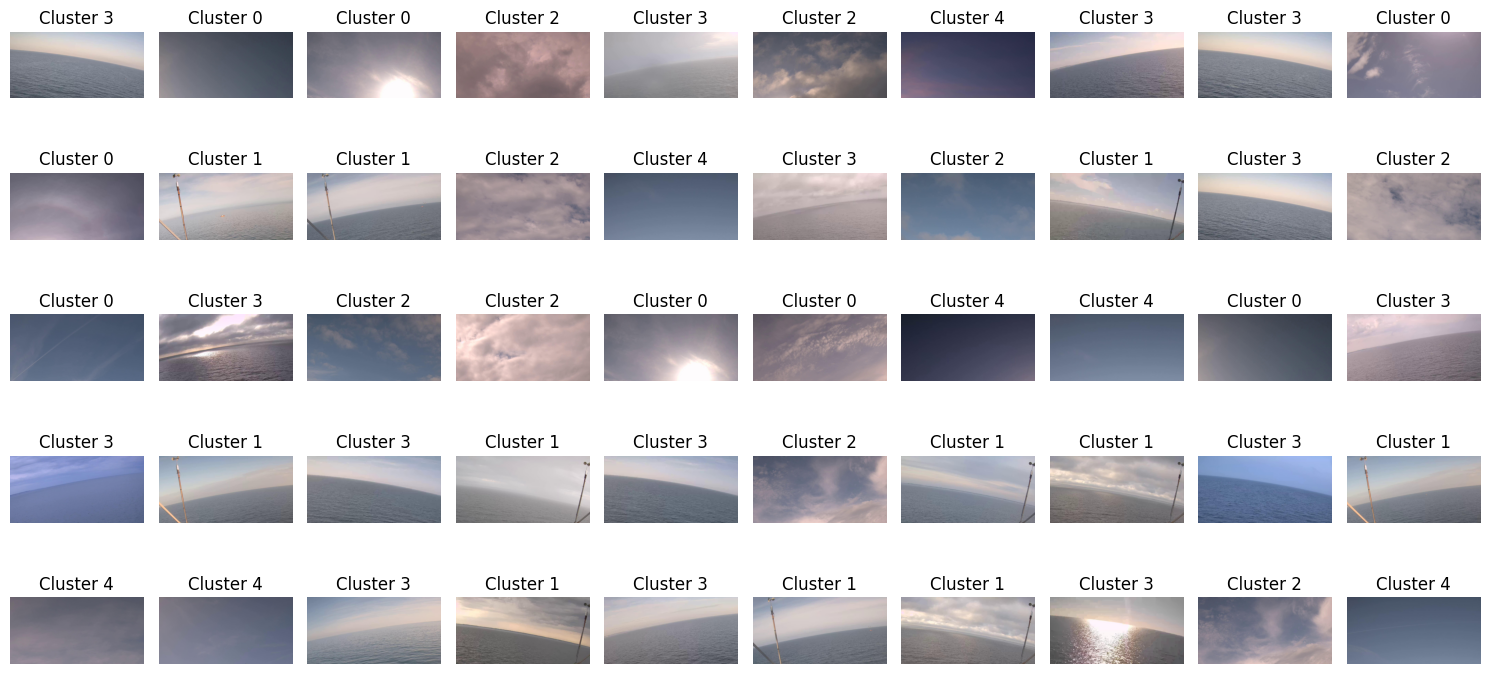

In [14]:
afficher_photos_aleatoires(photos_ciel_découpés, labels_kmeans_ciel, num_photos=50)

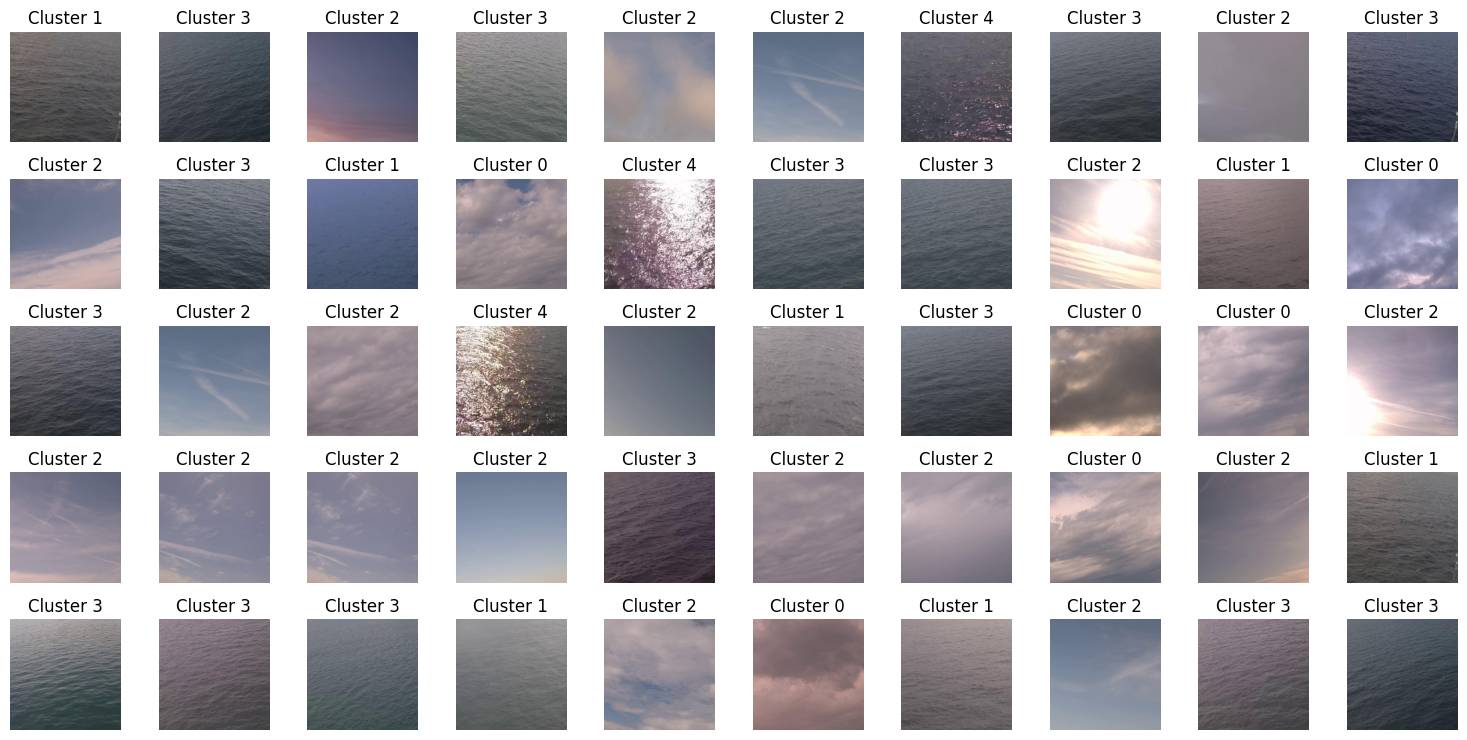

In [15]:
afficher_photos_aleatoires(photos_mer_découpés, labels_kmeans_mer, num_photos=50)

# Analyse des métriques

L'objectif est maintenant de pouvoir mesurer différentes grandeurs pour pouvoir distinguer et caractériser les clusters selon des paramètres météorologiques, on commence d'abord par les photos de ciel, plus révélatrices de la météo

Les différents paramètres qui vont être combinés sont la luminsoité, le flou, le contraste et le niveau de rouge. On calcule ces métriques avec la bilbiothèque OpenCV, qui est une bibliothèque utile pour extraire manuellement des features d'une image

Luminosité des clusters

In [16]:
cluster_luminosite_ciel = []
for cluster_id in range(k_optimal):
    #Liste des images par clusters
    cluster_images = [photos_ciel_découpés[i] for i in range(len(labels_kmeans_ciel)) if labels_kmeans_ciel[i] == cluster_id]
    #Liste de la luminosité moyenne de chaque image
    mean_luminosities = [np.mean(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)) for img in cluster_images]
    #Obtention de la luminosité moyenne du cluster
    cluster_luminosite_ciel.append(np.mean(mean_luminosities))

# Affichage des valeurs de luminosité moyenne
for i in range(k_optimal) : 
    print ("Luminosité du cluster", i, " : ", cluster_luminosite_ciel[i])

Luminosité du cluster 0  :  125.66862214708367
Luminosité du cluster 1  :  160.9188298694816
Luminosité du cluster 2  :  136.53639475375053
Luminosité du cluster 3  :  154.64840315296004
Luminosité du cluster 4  :  102.32631355467895


In [17]:
cluster_luminosite_mer = []
for cluster_id in range(k_optimal):
    #Liste des images par clusters
    cluster_images = [photos_mer_découpés[i] for i in range(len(labels_kmeans_mer)) if labels_kmeans_mer[i] == cluster_id]
    #Liste de la luminosité moyenne de chaque image
    mean_luminosities = [np.mean(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)) for img in cluster_images]
    #Obtention de la luminosité moyenne du cluster
    cluster_luminosite_mer.append(np.mean(mean_luminosities))

# Affichage des valeurs de luminosité moyenne
for i in range(k_optimal) : 
    print ("Luminosité du cluster", i, " : ", cluster_luminosite_mer[i])

Luminosité du cluster 0  :  141.74094487408289
Luminosité du cluster 1  :  112.11892063547607
Luminosité du cluster 2  :  140.63353345439745
Luminosité du cluster 3  :  86.34291392412348
Luminosité du cluster 4  :  117.1337064247472


Flou des clusters

In [18]:
def calculer_flou(image):
    gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    laplacian_var = cv2.Laplacian(gray_image, cv2.CV_64F).var()
    return laplacian_var

# Calculer le niveau de flou moyen pour chaque cluster
cluster_flou_ciel = []
for cluster_id in range(k_optimal):
    # Filtrer les images appartenant au cluster courant
    cluster_images = [photos_ciel_découpés[i] for i in range(len(labels_kmeans_ciel)) if labels_kmeans_ciel[i] == cluster_id]
    # Calculer le niveau de flou pour chaque image du cluster
    flous = [calculer_flou(img) for img in cluster_images]
    # Ajouter le niveau de flou moyen du cluster à la liste
    cluster_flou_ciel.append(np.mean(flous) if flous else 0)

for i in range(k_optimal) : 
    print ("Niveau de flou du cluster", i, " : ", cluster_flou_ciel[i])

Niveau de flou du cluster 0  :  123.20605443855398
Niveau de flou du cluster 1  :  193.82907032425624
Niveau de flou du cluster 2  :  1.6277799652988136
Niveau de flou du cluster 3  :  257.6099409968829
Niveau de flou du cluster 4  :  0.35818456183846137


In [19]:
def calculer_flou(image):
    gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    laplacian_var = cv2.Laplacian(gray_image, cv2.CV_64F).var()
    return laplacian_var

# Calculer le niveau de flou moyen pour chaque cluster
cluster_flou_mer = []
for cluster_id in range(k_optimal):
    # Filtrer les images appartenant au cluster courant
    cluster_images = [photos_mer_découpés[i] for i in range(len(labels_kmeans_mer)) if labels_kmeans_mer[i] == cluster_id]
    # Calculer le niveau de flou pour chaque image du cluster
    flous = [calculer_flou(img) for img in cluster_images]
    # Ajouter le niveau de flou moyen du cluster à la liste
    cluster_flou_mer.append(np.mean(flous) if flous else 0)

for i in range(k_optimal) : 
    print ("Niveau de flou du cluster", i, " : ", cluster_flou_mer[i])

Niveau de flou du cluster 0  :  2.403974504872869
Niveau de flou du cluster 1  :  84.73513520207736
Niveau de flou du cluster 2  :  1.1476329169804422
Niveau de flou du cluster 3  :  346.48837798805204
Niveau de flou du cluster 4  :  2293.9071931181215


Contraste des clusters

In [20]:
def calculer_contraste(image):
    gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    contrast = np.std(gray_image)  # Écart type des intensités
    return contrast

# Calculer le contraste moyen pour chaque cluster
cluster_contraste_ciel = []
for cluster_id in range(k_optimal):
    # Filtrer les images appartenant au cluster courant
    cluster_images = [photos_ciel_découpés[i] for i in range(len(labels_kmeans_ciel)) if labels_kmeans_ciel[i] == cluster_id]
    # Calculer le contraste pour chaque image du cluster
    contrastes = [calculer_contraste(img) for img in cluster_images]
    # Ajouter le contraste moyen du cluster à la liste
    cluster_contraste_ciel.append(np.mean(contrastes) if contrastes else 0)

for i in range (k_optimal) : 
    print ("Niveau de contraste du cluster ", i, " : ", cluster_contraste_ciel[i])

Niveau de contraste du cluster  0  :  26.727343404960475
Niveau de contraste du cluster  1  :  34.192985479666376
Niveau de contraste du cluster  2  :  16.81622483744546
Niveau de contraste du cluster  3  :  37.667876371896725
Niveau de contraste du cluster  4  :  13.064932929458859


In [21]:
def calculer_contraste(image):
    gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    contrast = np.std(gray_image)  # Écart type des intensités
    return contrast

# Calculer le contraste moyen pour chaque cluster
cluster_contraste_mer = []
for cluster_id in range(k_optimal):
    # Filtrer les images appartenant au cluster courant
    cluster_images = [photos_mer_découpés[i] for i in range(len(labels_kmeans_mer)) if labels_kmeans_mer[i] == cluster_id]
    # Calculer le contraste pour chaque image du cluster
    contrastes = [calculer_contraste(img) for img in cluster_images]
    # Ajouter le contraste moyen du cluster à la liste
    cluster_contraste_mer.append(np.mean(contrastes) if contrastes else 0)

for i in range (k_optimal) : 
    print ("Niveau de contraste du cluster ", i, " : ", cluster_contraste_mer[i])

Niveau de contraste du cluster  0  :  26.356539212917962
Niveau de contraste du cluster  1  :  18.809648343412235
Niveau de contraste du cluster  2  :  16.602839000925663
Niveau de contraste du cluster  3  :  24.34354641322524
Niveau de contraste du cluster  4  :  47.02770459399439


Niveau de rouge des clusters

In [22]:
def calculer_niveau_rouge(image):
    red_channel = np.array(image)[:, :, 0]  # Extraire le canal rouge
    niveau_rouge = np.mean(red_channel)  # Moyenne des valeurs rouges
    return niveau_rouge

# Calculer le niveau moyen des rouges pour chaque cluster
cluster_rouge_ciel = []
for cluster_id in range(k_optimal):
    # Filtrer les images appartenant au cluster courant
    cluster_images = [photos_ciel_découpés[i] for i in range(len(labels_kmeans_ciel)) if labels_kmeans_ciel[i] == cluster_id]
    # Calculer le niveau rouge pour chaque image du cluster
    niveaux_rouges = [calculer_niveau_rouge(img) for img in cluster_images]
    # Ajouter le niveau rouge moyen du cluster à la liste
    cluster_rouge_ciel.append(np.mean(niveaux_rouges) if niveaux_rouges else 0)

# Afficher le niveau moyen des rouges pour chaque cluster
for i in range(k_optimal):
    print("Niveau moyen des rouges du cluster", i, ":", cluster_rouge_ciel[i])

Niveau moyen des rouges du cluster 0 : 126.56404386212078
Niveau moyen des rouges du cluster 1 : 161.0282493851511
Niveau moyen des rouges du cluster 2 : 141.71711239615084
Niveau moyen des rouges du cluster 3 : 156.03337756910497
Niveau moyen des rouges du cluster 4 : 96.3460516199138


In [23]:
def calculer_niveau_rouge(image):
    red_channel = np.array(image)[:, :, 0]  # Extraire le canal rouge
    niveau_rouge = np.mean(red_channel)  # Moyenne des valeurs rouges
    return niveau_rouge

# Calculer le niveau moyen des rouges pour chaque cluster
cluster_rouge_mer = []
for cluster_id in range(k_optimal):
    # Filtrer les images appartenant au cluster courant
    cluster_images = [photos_mer_découpés[i] for i in range(len(labels_kmeans_mer)) if labels_kmeans_mer[i] == cluster_id]
    # Calculer le niveau rouge pour chaque image du cluster
    niveaux_rouges = [calculer_niveau_rouge(img) for img in cluster_images]
    # Ajouter le niveau rouge moyen du cluster à la liste
    cluster_rouge_mer.append(np.mean(niveaux_rouges) if niveaux_rouges else 0)

# Afficher le niveau moyen des rouges pour chaque cluster
for i in range(k_optimal):
    print("Niveau moyen des rouges du cluster", i, ":", cluster_rouge_mer[i])

Niveau moyen des rouges du cluster 0 : 151.32839976204642
Niveau moyen des rouges du cluster 1 : 112.27772614340203
Niveau moyen des rouges du cluster 2 : 141.05507749146815
Niveau moyen des rouges du cluster 3 : 83.03971368808888
Niveau moyen des rouges du cluster 4 : 122.55501873884593
